# DeepSet Flow Matching Posterior Estimation

This notebook demonstrates how to perform flow matching posterior estimation (FMPE) using a DeepSet architecture with LAMPE.

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import zuko

from itertools import islice
from lampe.data import JointLoader
from lampe.plots import corner, mark_point, nice_rc
from lampe.utils import GDStep
from tqdm import trange

from fmpe_deep_sets import DeepSetFMPE, DeepSetFMPELoss

## Simulator

We define and test a simple template simulator function and a prior distribution for our parameters. The simulator mimics the generation of observations based on the input parameters. The simulator is permutation invariant to the order of the input parameters.

In [2]:
LABELS = [r'$\theta_1$', r'$\theta_2$', r'$\theta_3$']
LOWER = -torch.ones(3)
UPPER = torch.ones(3)

prior = zuko.distributions.BoxUniform(LOWER, UPPER)

def simulator(theta: torch.Tensor) -> torch.Tensor:
    # Ensure permutation invariance by summing all parameters
    sum_theta = torch.sum(theta, dim=-1)
    # Create a simple simulation output that is permutation invariant
    x = torch.stack([
        sum_theta + 0.1 * torch.randn_like(sum_theta),  # Adding noise for variability
        torch.square(sum_theta) + 0.1 * torch.randn_like(sum_theta),  # Squared term with noise
    ], dim=-1)
    # x = torch.stack([
    #     sum_theta,
    #     torch.square(sum_theta)  # Squared term
    # ], dim=-1)
    return x

# Testing the simulator with a sample and its permutation
theta = prior.sample()
x = simulator(theta)

print("Original theta and simulation output:")
print(theta, x, sep='\n')

theta = theta.unsqueeze(0)  # Reshape to 2D tensor for permutation
# Generating a permutation of theta
permuted_theta = theta[:, torch.randperm(theta.size(-1))]
# Reshape theta and permuted_theta to 1D tensors
theta = theta.view(-1)
permuted_theta = permuted_theta.view(-1)
# simulating again
x_permuted = simulator(permuted_theta)

print("\nPermuted theta and simulation output:")
print(permuted_theta, x_permuted, sep='\n')

Original theta and simulation output:
tensor([ 0.2909, -0.1453, -0.3511])
tensor([-0.1846, -0.0266])

Permuted theta and simulation output:
tensor([ 0.2909, -0.1453, -0.3511])
tensor([-0.2156,  0.0643])


In [3]:
loader = JointLoader(prior, simulator, batch_size=256, vectorized=True)

## Training

We train a DeepSetFMPE model to learn the vector field that induces a normalizing flow between the posterior distribution $p(\theta | x)$ and a standard Gaussian distribution $\mathcal{N}(0, I)$. The training involves minimizing the FMPE loss.

In [4]:
estimator = DeepSetFMPE(theta_dim=3, x_dim=2, freqs=5)
loss = DeepSetFMPELoss(estimator)
optimizer = optim.Adam(estimator.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 128)
step = GDStep(optimizer, clip=1.0)  # gradient descent step with gradient clipping

estimator.train()

for epoch in (bar := trange(128, unit='epoch')):
    losses = []

    for theta, x in islice(loader, 256):  # 256 batches per epoch
        losses.append(step(loss(theta, x)))

    bar.set_postfix(loss=torch.stack(losses).mean().item())

100%|██████████| 128/128 [00:28<00:00,  4.50epoch/s, loss=0.589]


## Inference

After training, we use the DeepSetFMPE model to perform inference. We sample from the normalizing flow $p_\phi(\theta | x)$ it induces.

In [5]:
theta_star = prior.sample()
x_star = simulator(theta_star)

# Permute theta_star to test permutation invariance
theta_star = theta_star.unsqueeze(0)  # Reshape to 2D tensor for permutation
# Generating a permutation of theta_star
permuted_theta_star = theta_star[:, torch.randperm(theta_star.size(-1))]
# Reshape theta_star and permuted_theta_star to 1D tensors
theta_star = theta_star.view(-1)
permuted_theta_star = permuted_theta_star.view(-1)
# simulating again
x_star_permuted = simulator(permuted_theta_star)

estimator.eval()

with torch.no_grad():
    # Evaluate the log probability and sample for the original theta_star
    log_p_original = estimator.flow(x_star).log_prob(theta_star)
    samples_original = estimator.flow(x_star).sample((2**14,))
    
    # Evaluate the log probability and sample for the permuted theta_star
    log_p_permuted = estimator.flow(x_star_permuted).log_prob(permuted_theta_star)
    samples_permuted = estimator.flow(x_star_permuted).sample((2**14,))
    
    # Debug: Check if the posterior is permutation invariant by comparing log probabilities
    # assert torch.allclose(log_p_original, log_p_permuted, atol=1e-5), "Posterior is not permutation invariant"


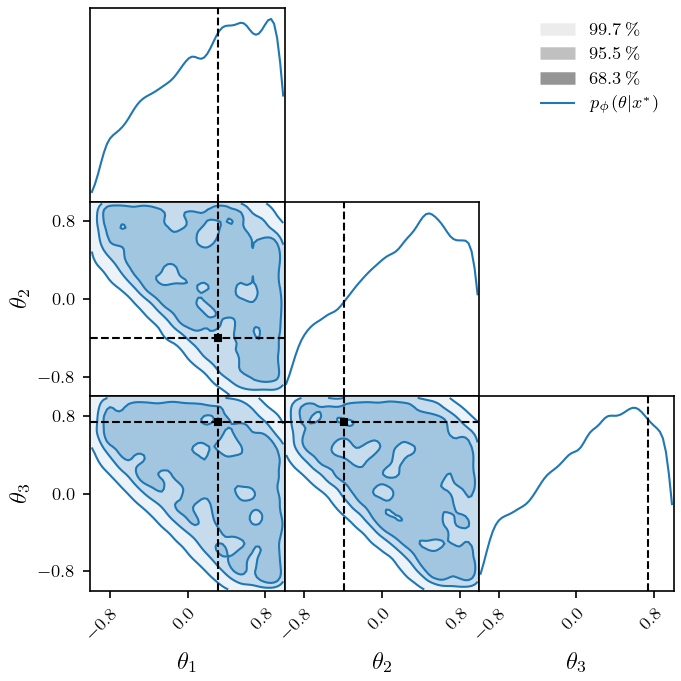

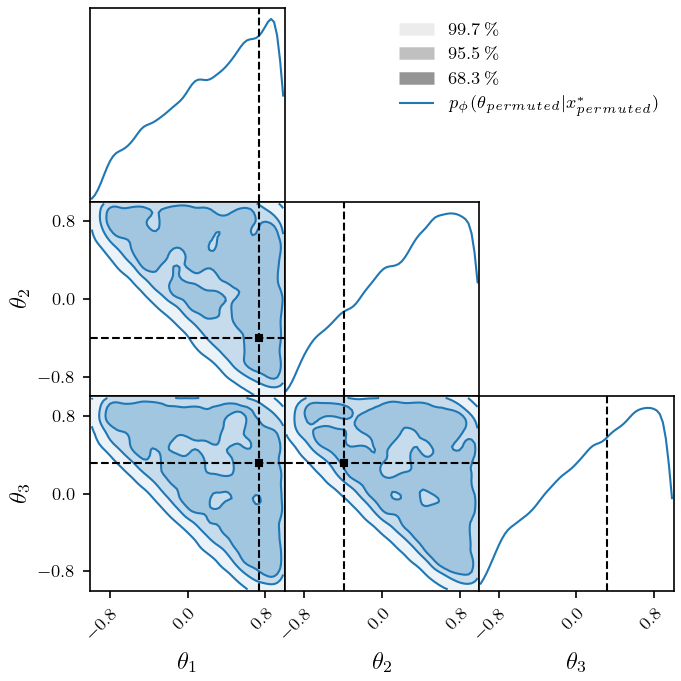

In [6]:
plt.rcParams.update(nice_rc(latex=True))  # nicer plot settings

# Plot for original samples and theta_star
fig_original = corner(
    samples_original,
    smooth=2,
    domain=(LOWER, UPPER),
    labels=LABELS,
    legend=r'$p_\phi(\theta | x^*)$',
    figsize=(4.8, 4.8),
)
mark_point(fig_original, theta_star)

# Plot for permuted samples and permuted_theta_star
fig_permuted = corner(
    samples_permuted,
    smooth=2,
    domain=(LOWER, UPPER),
    labels=LABELS,
    legend=r'$p_\phi(\theta_{permuted} | x^*_{permuted})$',
    figsize=(4.8, 4.8),
)
mark_point(fig_permuted, permuted_theta_star)


## Interpretation of the Corner Plot of Posterior Distributions

The visualization presented is a corner plot, which is commonly used in statistical analysis to illustrate the posterior distributions of multiple parameters and their pairwise relationships. This plot includes marginal distributions for each parameter along the diagonal and the joint distributions for each pair of parameters in the off-diagonal plots. Here's a detailed interpretation of this plot:

### Marginal Distributions

- **Diagonal Plots**: Each plot along the diagonal shows the marginal distribution of a parameter ($\theta_1$, $\theta_2$, $\theta_3$).
  - The curves represent the probability density of the parameters.
  - Vertical dashed lines indicate the median and the 68.3%, 95.5%, and 99.7% credible intervals, providing a visual summary of the uncertainty and the spread of each parameter's distribution.

### Joint Distributions

- **Off-Diagonal Plots**: Each off-diagonal plot shows the joint distribution between a pair of parameters.
  - Contour lines represent areas of increasing density, where darker shades correspond to higher probability regions.
  - The plots help in understanding the correlation or independence between parameters. For instance, a circular contour suggests little to no correlation, whereas elongated contours indicate stronger correlations.

### Interpretation of Parameter Behaviors

- **Correlations**: From the contour plots, we can observe the relationships between parameters:
  - $\theta_1$ and $\theta_2$ show some degree of correlation as indicated by the elongated contour lines.
  - $\theta_2$ and $\theta_3$ appear to be less correlated, as the contours are more circular.
  - $\theta_1$ and $\theta_3$ also show a pattern of correlation similar to that between $\theta_1$ and $\theta_2$.

- **Uncertainty and Confidence**:
  - The width of the intervals on the diagonal plots indicates the level of uncertainty in the estimates of each parameter. Narrower intervals suggest higher confidence in the parameter's estimate.
  - The spread of the contour lines in the joint plots provides insight into the joint uncertainty of parameter estimates.

### Summary

This corner plot is instrumental in visualizing the complex relationships and uncertainties inherent in the model's parameters. By examining both the marginal and joint distributions, we can gain a comprehensive understanding of the parameter space, which is crucial for making informed decisions based on the model's outputs. The plot also highlights areas where the model is more or less certain, guiding potential areas for model improvement or further data collection.